# Model Inference
[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/hsimonfroy/benchmark-field-level/blob/main/examples/infer_model.ipynb)

Infer from a cosmological model via MCMC samplers.

In [1]:
import os; os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION']='.5' # NOTE: jax preallocates GPU (default 75%)
import matplotlib.pyplot as plt
import numpy as np
from jax import numpy as jnp, random as jr, config as jconfig, devices as jdevices, jit, vmap, grad, debug, tree
jconfig.update("jax_enable_x64", True)
print(jdevices())

from functools import partial
from flbench.model import FieldLevelModel, default_config
from flbench.utils import pdump, pload
from flbench.mcbench import sample_and_save

%matplotlib inline
%load_ext autoreload
%autoreload 2
!hostname

[cuda(id=0)]
feynmangpu04.cluster.local


/feynman/work/dphp/hs276503/envs/montenvtest3/lib/python3.12/pty.py:95: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


## Experimental setup
### Instantiate model
We can see how the model is actually reparametrized.

# CONFIG
{'a_obs': 0.5,
 'box_shape': array([320., 320., 320.]),
 'evolution': 'lpt',
 'gxy_density': 0.001,
 'latents': {'Omega_m': {'group': 'cosmo',
                         'high': 1.0,
                         'label': '{\\Omega}_m',
                         'loc': 0.3111,
                         'loc_fid': 0.3111,
                         'low': 0.05,
                         'scale': 0.5,
                         'scale_fid': 0.02},
             'b1': {'group': 'bias',
                    'label': '{b}_1',
                    'loc': 1.0,
                    'loc_fid': 1.0,
                    'scale': 0.5,
                    'scale_fid': 0.04},
             'b2': {'group': 'bias',
                    'label': '{b}_2',
                    'loc': 0.0,
                    'loc_fid': 0.0,
                    'scale': 2.0,
                    'scale_fid': 0.02},
             'bn2': {'group': 'bias',
                     'label': '{b}_{\\nabla^2}',
                     'loc': 0.0,
 

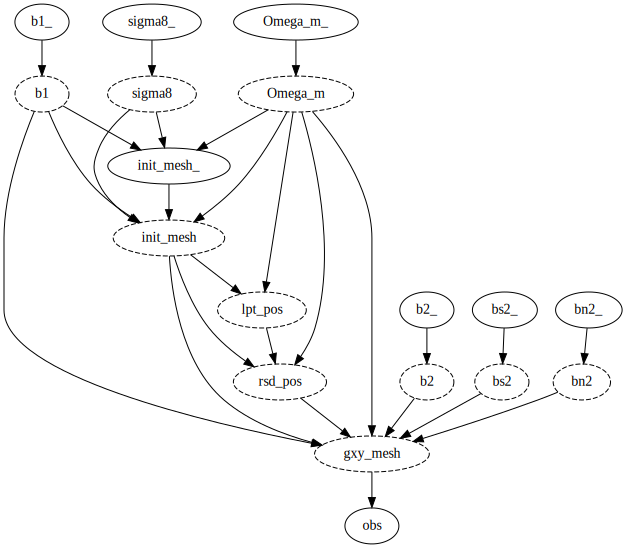

In [5]:
# model = FieldLevelModel(**default_config | {'box_shape': 3*(1280,), 'mesh_shape': 3* (256,)})
model = FieldLevelModel(**default_config)
print(model)
model.render()

###  Generate an observation and condition the model on it
We can see all the free parameters in the model, that we will subsequently sample.

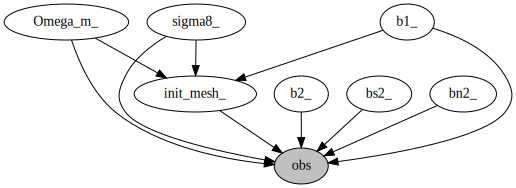

In [6]:
save_dir = "save_dir/"
os.makedirs(save_dir, exist_ok=True)

truth = {'Omega_m': 0.3, 
        'sigma8': 0.8, 
        'b1': 1.,
        'b2':0., 
        'bs2':0., 
        'bn2': 0.}

truth = model.predict(samples=truth, hide_base=False, hide_samp=False, frombase=True)
model.save(save_dir+"model.p")    
pdump(truth, save_dir+"truth.p")

model.reset() # reset any previous blocking or conditioning
model.condition({'obs': truth['obs']})
model.block() # hide parameters that we do not need to trace and save
model.render()

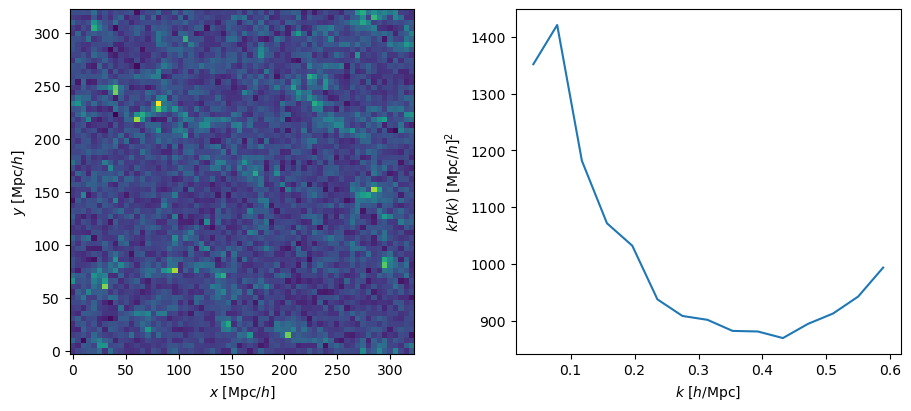

In [7]:
# Plot the observed galaxy density field
from flbench.plot import plot_mesh, plot_pow
plt.figure(figsize=(9, 4), layout='constrained')

plt.subplot(121)
plot_mesh(truth['obs'], model.box_shape, 0.1, axis=-2)

plt.subplot(122)
kpow = model.spectrum(truth['obs'])
plot_pow(*kpow);

## Perform the inference

### Warmup the field only

In [5]:
sampler = 'MCLMC'
n_samples, n_runs, n_chains = 32, 2, 8
tune_mass = True

model.reset()
model.condition({'obs': truth['obs']} | model.loc_fid, frombase=True)
model.block()

init_params_ = jit(vmap(partial(model.kaiser_post, delta_obs=truth['obs']-1)))(jr.split(jr.key(45), n_chains))    
init_mesh_ = {k: init_params_[k] for k in ['init_mesh_']}

from flbench.samplers import get_mclmc_warmup
warmup_fn = jit(vmap(get_mclmc_warmup(model.logpdf, n_steps=2**10, config=None, 
                            desired_energy_var=1e-6, diagonal_preconditioning=False)))
state, config = warmup_fn(jr.split(jr.key(43), n_chains), init_mesh_)

pdump(state, save_dir+f"init_last_state.p")
pdump(config, save_dir+f"init_conf.p")
init_params_ |= state.position

model.reset()
model.condition({'obs': truth['obs']})
model.block()

Performed 1024.0 adaptation steps


### Warmup all parameters and run

In [6]:
from tqdm import tqdm
from numpyro import infer


if sampler in ['NUTS', 'HMC']:
    
    if sampler == "NUTS":
        kernel = infer.NUTS(
            model=model,
            # init_strategy=numpyro.infer.init_to_value(values=fiduc_params)
            step_size=1e-3, 
            max_tree_depth=10,
            target_accept_prob=0.65,
            adapt_mass_matrix=tune_mass,
            )
        
    elif sampler == "HMC":
        kernel = infer.HMC(
            model=model,
            step_size=1e-3, 
            # Heuristic mean_length_steps_NUTS / 2, compare with gaussian pi.
            trajectory_length=4.4 / 2, 
            target_accept_prob=0.65,
            adapt_mass_matrix=tune_mass,
            )

    mcmc = infer.MCMC(
        sampler=kernel,
        num_warmup=n_samples,
        num_samples=n_samples, # for each run
        num_chains=n_chains,
        chain_method="vectorized",
        progress_bar=True,)
    
    mcmc_runned = sample_and_save(mcmc, save_dir, 0, n_runs, extra_fields=['num_steps'], init_params=init_params_)


elif sampler == 'NUTSwG':
    from flbench.samplers import nutswg_init, get_nutswg_warm, get_nutswg_run
    step_fn, init_fn, conf, init_state_fn = nutswg_init(model.logpdf)

    warmup_fn = jit(vmap(get_nutswg_warm(model.logpdf, 
                                         conf, 
                                         n_samples, 
                                         progress_bar=False)))
    state = vmap(init_state_fn)(init_params_)

    samples, infos, state, conf = warmup_fn(jr.split(jr.key(43), n_chains), state)
    jnp.savez(save_dir+f"_{0}.npz", **samples | {k:infos[k] for k in ['n_evals']})
    pdump(state, save_dir+"last_state.p")
    pdump(conf, save_dir+'conf.p')
    pdump(tree.map(jnp.mean, infos), save_dir+'infos.p')
    
    run_fn = jit(vmap(get_nutswg_run(model.logpdf, 
                                     step_fn, 
                                     init_fn, 
                                     n_samples, 
                                     progress_bar=False)))
    key = jr.key(42)
    for i_run in tqdm(range(1, n_runs + 1)):
        print(f"run {i_run}/{n_runs}")
        key, run_key = jr.split(key, 2)
        samples, infos, state = run_fn(jr.split(run_key, n_chains), state, conf)

        print("infos:", tree.map(lambda x: jnp.mean(x, 1), infos))
        jnp.savez(save_dir+f"_{i_run}.npz", **samples | {k:infos[k] for k in ['n_evals']})
        pdump(state, save_dir+"last_state.p")



elif sampler == 'MAMS':
    from flbench.samplers import get_mams_warmup, get_mams_run
    from blackjax.adaptation.mclmc_adaptation import MCLMCAdaptationState

    warmup_fn = jit(vmap(get_mams_warmup(model.logpdf, 
                                              n_steps=2**4, 
                                              config=None, 
                                              diagonal_preconditioning=tune_mass)))
    state, config = warmup_fn(jr.split(jr.key(43), n_chains), init_params_)
    
    eval_per_ess = 5e2
    ss = jnp.median(config.step_size)
    config = MCLMCAdaptationState(L=0.3 * eval_per_ess/2 * ss, 
                                step_size=ss, 
                                inverse_mass_matrix=jnp.median(config.inverse_mass_matrix, 0))
    config = tree.map(lambda x: jnp.broadcast_to(x, (n_chains, *jnp.shape(x))), config)

    pdump(state, save_dir+"last_state.p")
    pdump(config, save_dir+"conf.p")
    
    run_fn = jit(vmap(get_mams_run(model.logpdf, 
                                        n_samples, 
                                        thinning=1, 
                                        progress_bar=False)))

    key = jr.key(42)
    for i_run in tqdm(range(1, n_runs + 1)):
        print(f"run {i_run}/{n_runs}")
        key, run_key = jr.split(key, 2)
        state, samples = run_fn(jr.split(run_key, n_chains), state, config)
        
        print("n_evals:", jnp.mean(samples['n_evals'], 1), '\n')
        jnp.savez(save_dir+f"_{i_run}.npz", **samples)
        pdump(state, save_dir+"last_state.p")


elif sampler == 'MCLMC':
    from flbench.samplers import get_mclmc_warmup, get_mclmc_run
    from blackjax.adaptation.mclmc_adaptation import MCLMCAdaptationState

    warmup_fn = jit(vmap(get_mclmc_warmup(model.logpdf, n_steps=2**10, config=None, 
                                        desired_energy_var=1e-6, diagonal_preconditioning=tune_mass)))
    state, config = warmup_fn(jr.split(jr.key(43), n_chains), init_params_)

    eval_per_ess = 1e3
    ss = jnp.median(config.step_size)
    config = MCLMCAdaptationState(L=0.4 * eval_per_ess/2 * ss, 
                                step_size=ss, 
                                inverse_mass_matrix=jnp.median(config.inverse_mass_matrix, 0))
    config = tree.map(lambda x: jnp.broadcast_to(x, (n_chains, *jnp.shape(x))), config)

    pdump(state, save_dir+f"last_state.p")
    pdump(config, save_dir+f"conf.p")
    
    run_fn = jit(vmap(get_mclmc_run(model.logpdf, n_samples, thinning=16, progress_bar=False)))

    key = jr.key(42)
    for i_run in tqdm(range(1, n_runs + 1)):
        print(f"run {i_run}/{n_runs}")
        key, run_key = jr.split(key, 2)
        state, samples = run_fn(jr.split(run_key, n_chains), state, config)
        
        print("MSE per dim:", jnp.mean(samples['mse_per_dim'], 1), '\n')
        jnp.savez(save_dir+f"_{i_run}.npz", **samples)
        pdump(state, save_dir+f"last_state.p")


Performed 878.0 adaptation steps


  0%|          | 0/2 [00:00<?, ?it/s]

run 1/2
MSE per dim: [1.63670692e-07 1.75704276e-07 2.84824577e-07 2.61713663e-07
 1.74576304e-07 1.54436562e-07 1.76927752e-07 1.75897957e-07] 



 50%|█████     | 1/2 [02:38<02:38, 158.91s/it]

run 2/2
MSE per dim: [1.53748158e-07 1.62305417e-07 1.52152206e-07 1.62890185e-07
 1.71346603e-07 1.57929120e-07 1.72105132e-07 1.65337885e-07] 



100%|██████████| 2/2 [03:34<00:00, 107.47s/it]
